<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/02_LangGraph_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [927]:
!pip install langgraph langchain_groq langchain langchain-google-genai pydantic

Tool Management

In [928]:
from typing import Union

def add_two_number(a:Union[int, str] ,b:Union[int, str] ) -> int:
    """
    This function add two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Sum of two valus
    """
    int_a = int(a)
    int_b = int(b)

    return int_a+int_b

def subtract_two_number(a:Union[int,str],b:Union[int,str]) -> int:
    """_summary_
     This function subtract two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Subtract two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a-b

def multiply_two_number(a:Union[int,str],b:Union[int,str]) -> int:
    """_summary_
     This function multiply two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: multiply two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a*b

Model

In [929]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict,Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

LLM With Tools

In [930]:
from langchain_groq import ChatGroq
from google.colab import userdata

llm = ChatGroq(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    api_key= userdata.get("groq_key")
)

llm_bind_tools = llm.bind_tools([add_two_number,subtract_two_number, multiply_two_number])

Invoke LLM

In [931]:
invoke_llm = llm_bind_tools.invoke("What is the result of adding 2 and 5?")
invoke_llm.tool_calls

[{'name': 'add_two_number',
  'args': {'a': '2', 'b': '5'},
  'id': 'crxfck76d',
  'type': 'tool_call'}]

LangGraph Tool Calling

In [932]:
def llm_tool_calling(state: State) -> State:
    """
    This function is called to invoke the LLM with tools.

    :param state: The current state containing messages
    :return: Updated state with the response from the LLM
    """
    response = llm_bind_tools.invoke(state["messages"])
    state["messages"].append(response)
    return state

In [933]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [934]:
graph = StateGraph(State)

In [935]:
graph.add_node("llm", llm_tool_calling)
graph.add_node("tools", ToolNode(tools=[add_two_number]))

In [936]:
graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", tools_condition)
graph.add_edge("tools", "llm")

In [937]:
graph_builder = graph.compile()

Print and verify the created Graph

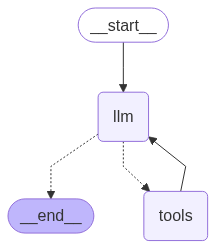

In [938]:
from IPython.display import display, Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

Invoke LLM

In [939]:
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
state = State(messages= HumanMessage(content="sum these two number 2 and 5"))

In [940]:
output = graph_builder.invoke(state)

In [941]:
import pprint
for msg in output['messages']:
     msg.pretty_print()

================================ Human Message =================================

sum these two number 2 and 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (3dn3gapqb)
 Call ID: 3dn3gapqb
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7
================================== Ai Message ==================================

The sum of 2 and 5 is 7.


We can also chain one or more tools togethor

In [942]:
multiple_tool_graph = StateGraph(State)

In [943]:
tools = [add_two_number, subtract_two_number, multiply_two_number]
tool_node = ToolNode(tools=tools)

multiple_tool_graph.add_node("llm", llm_tool_calling)
multiple_tool_graph.add_node("tools", ToolNode(tools=tools))

In [944]:
multiple_tool_graph.add_edge(START, "llm")
multiple_tool_graph.add_conditional_edges("llm", tools_condition)
multiple_tool_graph.add_edge("tools", "llm")

In [945]:
graph_builder_multiple_tools = multiple_tool_graph.compile()

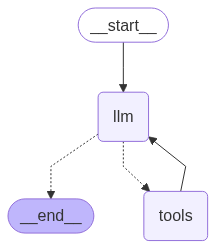

In [946]:
display(Image(graph_builder_multiple_tools.get_graph().draw_mermaid_png()))

In [947]:
state_message = State(messages= HumanMessage(content="Multiply 2 and 3 and add 5 to the output "))

In [948]:
result = graph_builder_multiple_tools.invoke(state_message)

In [949]:
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Multiply 2 and 3 and add 5 to the output 
================================== Ai Message ==================================
Tool Calls:
  add_two_number (rnwa5e274)
 Call ID: rnwa5e274
  Args:
    a: 5
    b: 6
  multiply_two_number (y0gy4md8t)
 Call ID: y0gy4md8t
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add_two_number

11
================================= Tool Message =================================
Name: multiply_two_number

Error: TypeError("can't multiply sequence by non-int of type 'str'")
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  add_two_number (hw3r8xbtc)
 Call ID: hw3r8xbtc
  Args:
    a: 5
    b: 6
  multiply_two_number (356npb8ws)
 Call ID: 356npb8ws
  Args:
    a: 2
    b: 3
================================= Tool Message =======================

Agent without memory

In [950]:
#output_res = graph_builder_multiple_tools.invoke(HumanMessage(content="what is the output from previous query" ))

In [951]:
# for item in output_res['messages']:
#     item.pretty_print()

Agent with memory

In [952]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [953]:
multiple_tool_graph = StateGraph(State)
multiple_tool_graph.add_node("llm", llm_tool_calling)
multiple_tool_graph.add_node("tools", ToolNode(tools=[add_two_number,subtract_two_number,multiply_two_number]))
multiple_tool_graph.add_edge(START, "llm")
multiple_tool_graph.add_conditional_edges("llm", tools_condition)
multiple_tool_graph.add_edge("tools", END)
graph_builder_memory = multiple_tool_graph.compile(checkpointer=memory)

In [954]:
state_message = State(messages= HumanMessage(content="Add two number 2 and 5"))

In [955]:
config = {"configurable":{"thread_id":"1"}}

In [956]:
res1 = graph_builder_memory.invoke(
    {"messages": [HumanMessage(content="Add two numbers 2 and 5")]},
    config
)

In [957]:
res2 = graph_builder_memory.invoke(
    {"messages": [HumanMessage(content="Add 25 to that number")]},
    config
)


In [958]:
for item in res2['messages']:
  item.pretty_print()

================================ Human Message =================================

Add two numbers 2 and 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (9c2qq6v5c)
 Call ID: 9c2qq6v5c
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7
================================ Human Message =================================

Add 25 to that number
================================== Ai Message ==================================
Tool Calls:
  add_two_number (0kpf5v7sh)
 Call ID: 0kpf5v7sh
  Args:
    a: 7
    b: 25
================================= Tool Message =================================
Name: add_two_number

32


In [959]:
res_memory = graph_builder_memory.invoke(HumanMessage(content="Add 35 to the output" ),config)

In [960]:
for item in res_memory['messages']:
  item.pretty_print()

================================ Human Message =================================

Add two numbers 2 and 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (9c2qq6v5c)
 Call ID: 9c2qq6v5c
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7
================================ Human Message =================================

Add 25 to that number
================================== Ai Message ==================================
Tool Calls:
  add_two_number (0kpf5v7sh)
 Call ID: 0kpf5v7sh
  Args:
    a: 7
    b: 25
================================= Tool Message =================================
Name: add_two_number

32
================================== Ai Message ==================================

The result of adding 25 to 7 is 32.
